What does the code do till now:
- Defines the amount of positive and negative items. 
- Defines the probability that a rater gives correct answer to the true positive and the true negative
- Also defines the number of raters per item

The Data Generation process:
- We then define the dataframe with item, true_answer and rater_id
- We add a randon number between 0 and 1 as a column
- Based on the random number, if the rand < p_true_pos, we add 1 else 0. Same for true negative but 0 and 1
- At the end we generate a table which captures the fraction of correct answers given by raters
- We also create a frequency table of the answer column

In [ ]:
install.packages("dplyr")
install.packages("magrittr")
install.packages("tidyr")

In [7]:
set.seed(42)
suppressPackageStartupMessages({
    library(dplyr)
    library(irr)
    library(irrCAC)
    library(tidyr)
    library(magrittr)
    library(ggplot2)
})


### Foundational code to showcase the data generation process and calculation of Krips Alpha

In [8]:
n_pos <- 100  # number of true positive items
n_neg <- 100  # Number of true negative items

p_pos_correct <- 0.7  # Probability that a rater gives correct answer to a true positive
p_neg_correct <- 0.7 # probability that a rater gives correct answer to a true negative

n_raters_per_item <- 10

In [9]:
items <- rep(1:(n_neg + n_pos))

d <- data.frame(item = rep(items, n_raters_per_item),
     true_answer = rep(c(rep(1, n_pos),
                     rep(0, n_neg)), n_raters_per_item))

# Creates a data frame 'd' with columns 'item' and 'true_answer'.
# 'item' repeats the sequence of item identifiers for each rater.
# 'true_answer' contains the true classifications (1 for positive, 0 for negative), repeated for each rater.

d <- d %>% dplyr::arrange(item)
# Arranges the data frame by the 'item' column.

d$rater <- 1:n_raters_per_item
# Assigns each row a rater ID, from 1 to the number of raters per item.

d$rand <- runif(nrow(d))
# Adds a column 'rand' with random numbers between 0 and 1 for each row (rating).

d_pos <- d %>%
  dplyr::filter(true_answer == 1) %>%
  dplyr::mutate(answer = ifelse(rand < p_pos_correct, 1, 0))
# Filters rows where 'true_answer' is 1 (true positives).
# Adds a column 'answer', where raters correctly identify positive items based on the probability 'p_pos_correct'.

d_neg <- d %>%
  dplyr::filter(true_answer == 0) %>%
  dplyr::mutate(answer = ifelse(rand < p_neg_correct, 0, 1))
# Filters rows where 'true_answer' is 0 (true negatives).
# Adds a column 'answer', where raters correctly identify negative items based on the probability 'p_neg_correct'.

d <- dplyr::bind_rows(d_pos, d_neg)
# Combines the positive and negative data frames back into one.

d %>%
  dplyr::mutate(correct = (true_answer == answer)) %>%
  dplyr::group_by(true_answer) %>%
  dplyr::summarise(m = mean(correct))
# This code first creates a new column 'correct' that is TRUE when the rater's answer matches the true answer.
# Then it groups the data by 'true_answer' and calculates the mean of the 'correct' column for each group.
# 'm' will represent the fraction of correct answers for each type of true answer (true positive or true negative).

table(d$answer)

# Assuming 'd' is your existing data frame
# Transforming 'd' into a format suitable for kripp.alpha
ratings_matrix <- d %>%
  select(item, rater, answer) %>%
  pivot_wider(names_from = rater, values_from = answer)

# Removing the item column to get the matrix format and taking transpose (for correct format for calculation of Krips Alpha)
binary_ratings_matrix <- t(as.matrix(ratings_matrix[,-1]))

binary_ratings_matrix

true_answer,m
<dbl>,<dbl>
0,0.689
1,0.707



   0    1 
 982 1018 

1,0,1,0,0,1,1,1,1,1,1,⋯,1,1,1,1,0,1,1,1,1,1
2,0,0,1,0,1,1,0,1,1,1,⋯,1,0,1,0,0,1,0,0,0,1
3,1,0,0,1,1,1,0,1,1,1,⋯,1,1,0,1,0,1,0,0,0,0
4,0,1,0,1,0,0,1,1,1,0,⋯,0,0,0,0,0,1,0,0,0,1
5,1,1,1,1,1,1,0,1,0,0,⋯,0,1,0,0,1,1,1,1,0,1
6,1,0,1,0,0,0,1,0,1,0,⋯,1,0,1,0,0,0,0,0,0,0
7,0,0,1,1,0,1,1,1,1,1,⋯,0,1,0,0,1,0,0,1,1,0
8,1,1,0,1,1,1,0,1,1,1,⋯,0,1,1,0,0,1,1,0,1,0
9,1,1,1,0,0,1,1,1,1,0,⋯,0,1,0,1,1,0,0,1,1,0
10,0,1,0,1,1,1,1,1,1,1,⋯,1,0,0,0,0,0,0,0,1,1


What should be the next step from here:
- Write code to calculate Krippendorf's alpha
- Generate the skew in data (number of TP and TN true items)

In [5]:
# Calculate Krippendorff's Alpha
alpha_result <- irr::kripp.alpha(binary_ratings_matrix, method = "nominal")
print(alpha_result)

 Krippendorff's alpha

 Subjects = 200 
   Raters = 10 
    alpha = 0.153 


We convert the above code to a function calculate_krippendorff_alpha which takes in the parameters n_pos, n_neg, p_pos_correct, p_neg_correct, n_raters_per_item, generates the data based on these parameters and then calculates the value of Krips alpha over that. 

In [6]:
calculate_krippendorff_alpha <- function(n_pos, n_neg, p_pos_correct, p_neg_correct, n_raters_per_item) {
    set.seed(42)
    # Create the data frame with true answers
    d <- data.frame(item = rep(1:(n_neg + n_pos), each = n_raters_per_item),
                    true_answer = rep(c(rep(1, n_pos), rep(0, n_neg)), each = n_raters_per_item))

    # Assign rater IDs and generate random numbers
    d$rater <- rep(1:n_raters_per_item, times = n_neg + n_pos)
    d$rand <- runif(nrow(d))

    # Assign answers based on true_answer and probabilities
    d$answer <- with(d, ifelse(true_answer == 1, ifelse(rand < p_pos_correct, 1, 0), 
                              ifelse(rand < p_neg_correct, 0, 1)))

    # Transform data into matrix format for Krippendorff's alpha calculation
    ratings_matrix <- d %>%
      select(item, rater, answer) %>%
      pivot_wider(names_from = rater, values_from = answer)

    binary_ratings_matrix <- t(as.matrix(ratings_matrix[,-1]))

    # Calculate Krippendorff's alpha
    alpha <- kripp.alpha(binary_ratings_matrix, method = "nominal")

    return(alpha$value)
}

# Example usage of the function
krippendorff_alpha <- calculate_krippendorff_alpha(100, 100, 0.99, 0.99, 10)
krippendorff_alpha

[1] 0.9624456

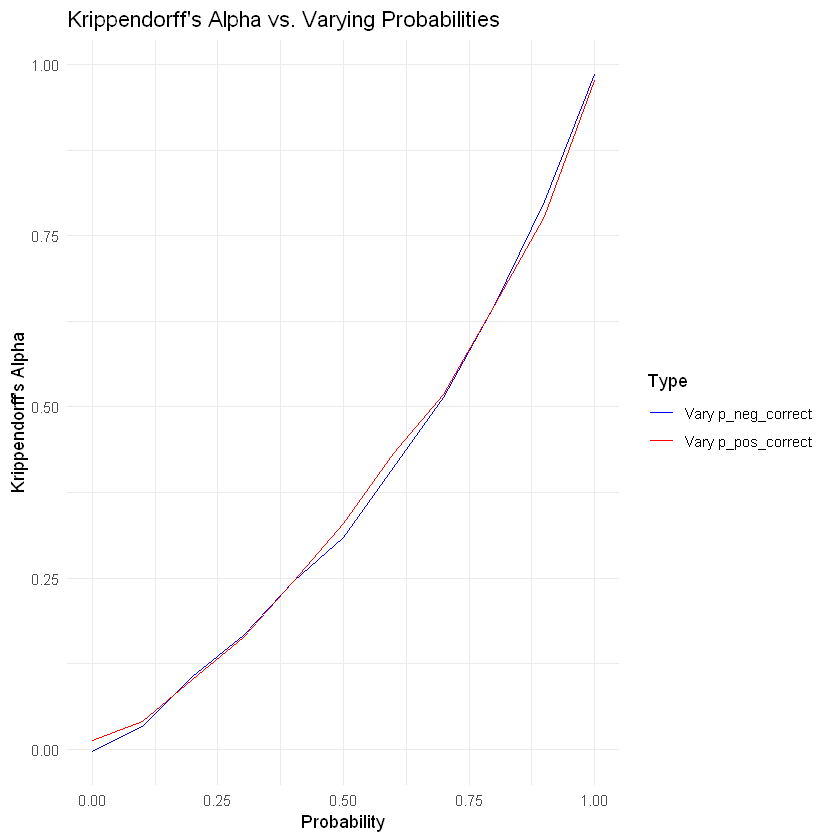

In [7]:
# Initialize vectors to store the values
probabilities <- seq(0, 1, by = 0.1)
alpha_values_pos_constant <- numeric(length(probabilities))
alpha_values_neg_constant <- numeric(length(probabilities))

# Constant values for p_pos_correct and p_neg_correct
constant_pos_correct <- 0.9  # Keeping p_pos_correct constant
constant_neg_correct <- 0.9  # Keeping p_neg_correct constant

# Calculate Krippendorff's alpha for varying p_neg_correct, keeping p_pos_correct constant
for (i in seq_along(probabilities)) {
    alpha_values_neg_constant[i] <- calculate_krippendorff_alpha(100, 100, constant_pos_correct, probabilities[i], 10)
}

# Calculate Krippendorff's alpha for varying p_pos_correct, keeping p_neg_correct constant
for (i in seq_along(probabilities)) {
  alpha_values_pos_constant[i] <- calculate_krippendorff_alpha(100, 100, probabilities[i], constant_neg_correct, 10)
}

data_to_plot <- data.frame(
    Probability = rep(probabilities, times = 2),
    KrippendorffAlpha = c(alpha_values_neg_constant, alpha_values_pos_constant),
    Type = rep(c("Vary p_neg_correct", "Vary p_pos_correct"), each = length(probabilities))
)

# Create the plot
ggplot(data_to_plot, aes(x = Probability, y = KrippendorffAlpha, color = Type, group = Type)) +
  geom_line() +
  ggtitle("Krippendorff's Alpha vs. Varying Probabilities") +
  xlab("Probability") +
  ylab("Krippendorff's Alpha") +
  scale_color_manual(values = c("blue", "red")) +
  theme_minimal()

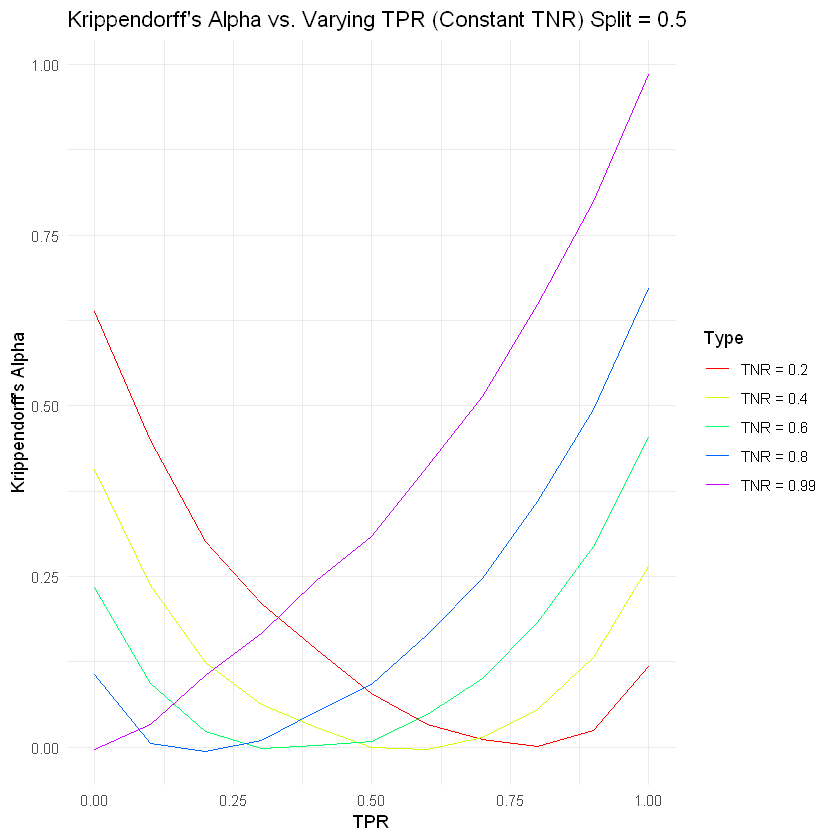

In [70]:
library(ggplot2)

# Initialize vectors
tpr_values <- seq(0, 1, by = 0.1)
tnr_values <- c(0.2, 0.4, 0.6, 0.8, 0.99)

# Prepare data for plotting
data_to_plot_tpr <- data.frame()

for (tnr in tnr_values) {
  alpha_values <- sapply(tpr_values, function(p) calculate_krippendorff_alpha(100, 100, tnr, p, 10))
  data_to_plot_tpr <- rbind(data_to_plot_tpr, data.frame(
    Probability = tpr_values,
    KrippendorffAlpha = alpha_values,
    Type = paste("TNR =", tnr)
  ))
}

# Create the first plot
ggplot(data_to_plot_tpr, aes(x = Probability, y = KrippendorffAlpha, color = Type, group = Type)) +
  geom_line() +
  ggtitle("Krippendorff's Alpha vs. Varying TPR (Constant TNR) Split = 0.5") +
  xlab("TPR") +
  ylab("Krippendorff's Alpha") +
  scale_color_manual(values = rainbow(length(tnr_values))) +
  theme_minimal()


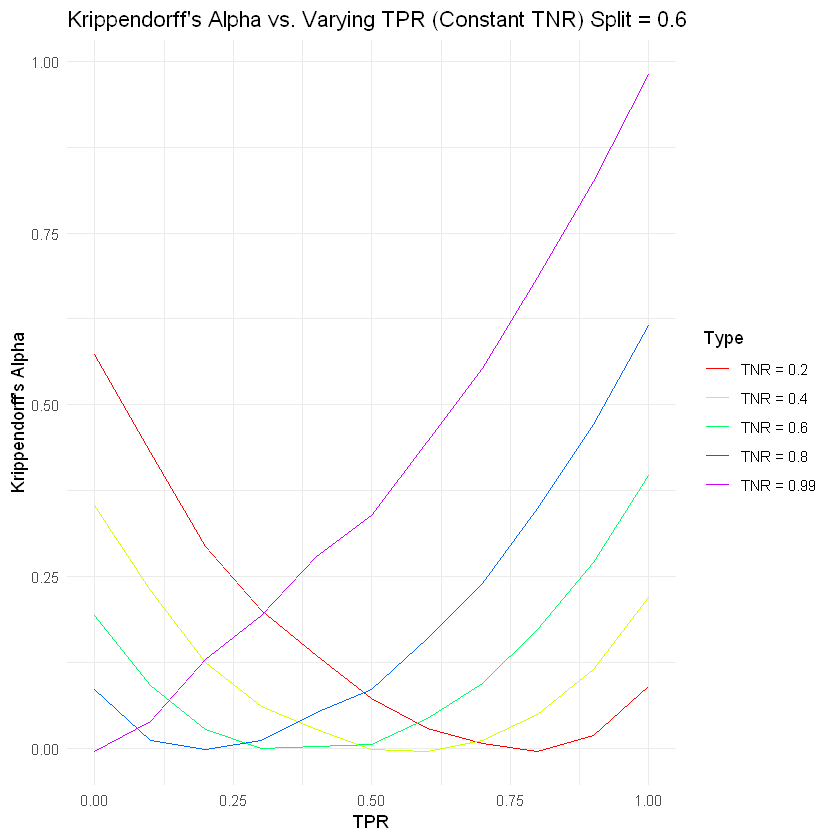

In [67]:
# Initialize vectors
probabilities <- seq(0, 1, by = 0.1)
tnr_values <- c(0.2, 0.4, 0.6, 0.8, 0.99)

# Prepare data for plotting
data_to_plot_tpr <- data.frame()

for (tnr in tnr_values) {
  alpha_values <- sapply(probabilities, function(p) calculate_krippendorff_alpha(120, 80, tnr, p, 10))
  data_to_plot_tpr <- rbind(data_to_plot_tpr, data.frame(
    Probability = probabilities,
    KrippendorffAlpha = alpha_values,
    Type = paste("TNR =", tnr)
  ))
}

# Create the first plot
ggplot(data_to_plot_tpr, aes(x = Probability, y = KrippendorffAlpha, color = Type, group = Type)) +
  geom_line() +
  ggtitle("Krippendorff's Alpha vs. Varying TPR (Constant TNR) Split = 0.6") +
  xlab("TPR") +
  ylab("Krippendorff's Alpha") +
  scale_color_manual(values = rainbow(length(tnr_values))) +
  theme_minimal()

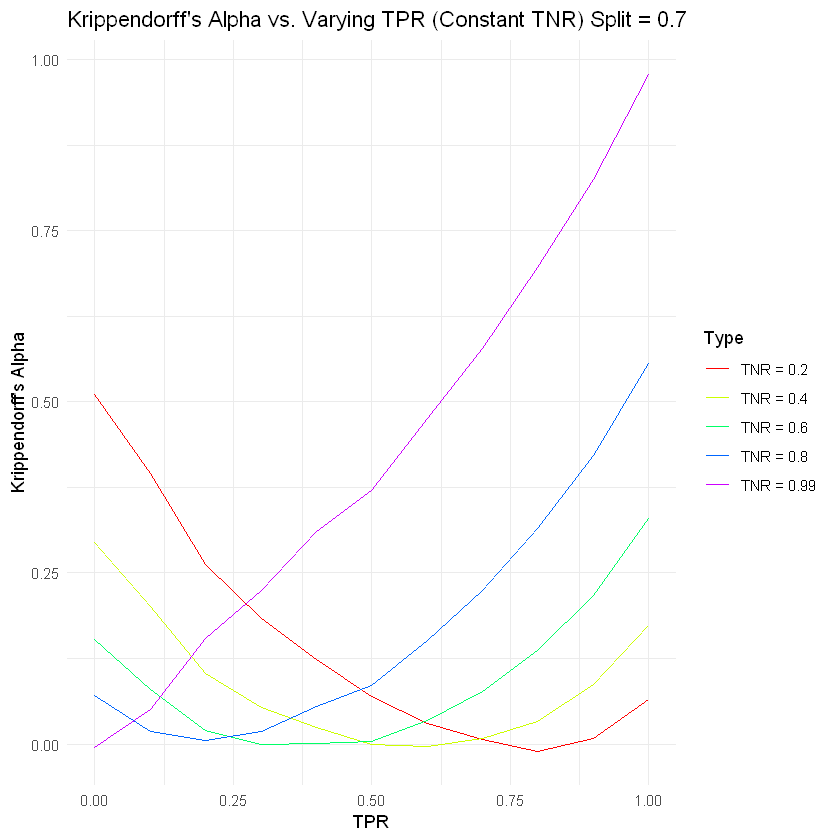

In [73]:
# Initialize vectors
tpr_values <- seq(0, 1, by = 0.1)
tnr_values <- c(0.2, 0.4, 0.6, 0.8, 0.99)

# Prepare data for plotting
data_to_plot_tpr <- data.frame()

for (tnr in tnr_values) {
  alpha_values <- sapply(tpr_values, function(p) calculate_krippendorff_alpha(140, 60, tnr, p, 10))
  data_to_plot_tpr <- rbind(data_to_plot_tpr, data.frame(
    Probability = tpr_values,
    KrippendorffAlpha = alpha_values,
    Type = paste("TNR =", tnr)
  ))
}

# Create the first plot
ggplot(data_to_plot_tpr, aes(x = Probability, y = KrippendorffAlpha, color = Type, group = Type)) +
  geom_line() +
  ggtitle("Krippendorff's Alpha vs. Varying TPR (Constant TNR) Split = 0.7") +
  xlab("TPR") +
  ylab("Krippendorff's Alpha") +
  scale_color_manual(values = rainbow(length(tnr_values))) +
  theme_minimal()

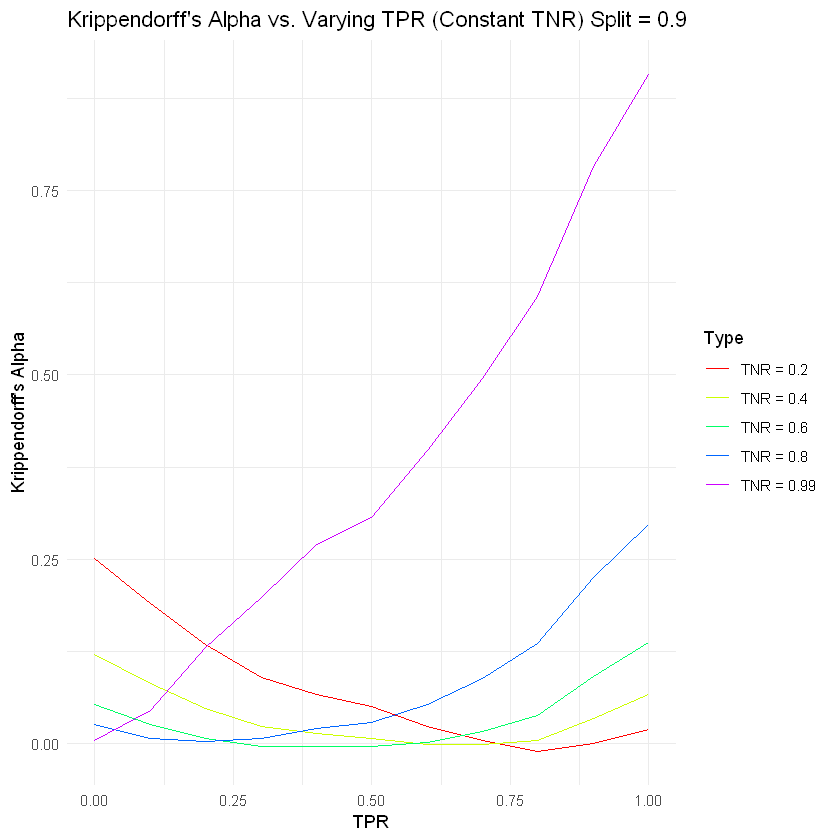

In [72]:
tpr_values <- seq(0, 1, by = 0.1)
tnr_values <- c(0.2, 0.4, 0.6, 0.8, 0.99)

# Prepare data for plotting
data_to_plot_tpr <- data.frame()

for (tnr in tnr_values) {
  alpha_values <- sapply(tpr_values, function(p) calculate_krippendorff_alpha(180, 20, tnr, p, 10))
  data_to_plot_tpr <- rbind(data_to_plot_tpr, data.frame(
    Probability = tpr_values,
    KrippendorffAlpha = alpha_values,
    Type = paste("TNR =", tnr)
  ))
}

# Create the first plot
ggplot(data_to_plot_tpr, aes(x = Probability, y = KrippendorffAlpha, color = Type, group = Type)) +
  geom_line() +
  ggtitle("Krippendorff's Alpha vs. Varying TPR (Constant TNR) Split = 0.9") +
  xlab("TPR") +
  ylab("Krippendorff's Alpha") +
  scale_color_manual(values = rainbow(length(tnr_values))) +
  theme_minimal()

In [8]:
calculate_krippendorff_alpha_with_accuracy <- function(n_pos, n_neg, accuracy, n_raters_per_item) {
    set.seed(42)
    # Create the data frame with true answers
    d <- data.frame(item = rep(1:(n_neg + n_pos), each = n_raters_per_item),
                    true_answer = rep(c(rep(1, n_pos), rep(0, n_neg)), each = n_raters_per_item))

    # Assign rater IDs and generate random numbers
    d$rater <- rep(1:n_raters_per_item, times = n_neg + n_pos)
    d$rand <- runif(nrow(d))

    # Assign answers based on true_answer and accuracy
    d$answer <- with(d, ifelse(true_answer == 1, ifelse(rand < accuracy, 1, 0), 
                              ifelse(rand < accuracy, 0, 1)))

    # Transform data into matrix format for Krippendorff's alpha calculation
    ratings_matrix <- d %>%
      select(item, rater, answer) %>%
      pivot_wider(names_from = rater, values_from = answer)

    binary_ratings_matrix <- t(as.matrix(ratings_matrix[,-1]))

    # Calculate Krippendorff's alpha
    alpha <- kripp.alpha(binary_ratings_matrix, method = "nominal")

    return(alpha$value)
}



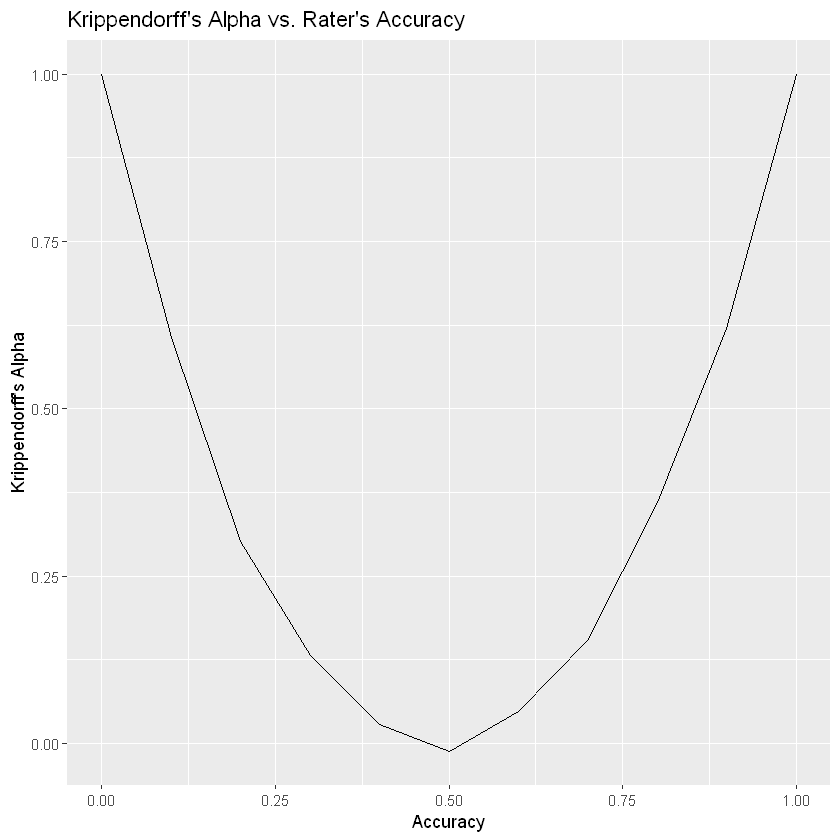

In [9]:
# Sequence of accuracy values
accuracies <- seq(0, 1, by = 0.1)

# Initialize a vector to store Krippendorff's alpha values
alpha_values <- numeric(length(accuracies))

# Calculate Krippendorff's alpha for each accuracy
for (i in seq_along(accuracies)) {
  alpha_values[i] <- calculate_krippendorff_alpha_with_accuracy(100, 100, accuracies[i], 10)
}

# Create the plot
data_to_plot <- data.frame(Accuracy = accuracies, KrippendorffAlpha = alpha_values)
ggplot(data_to_plot, aes(x = Accuracy, y = KrippendorffAlpha)) +
  geom_line() +
  ggtitle("Krippendorff's Alpha vs. Rater's Accuracy") +
  xlab("Accuracy") +
  ylab("Krippendorff's Alpha")

In [30]:
# total_items is the total number of items (both positive and negative).
# split_ratio is the proportion of positive items (a value between 0 and 1).

calculate_krippendorff_alpha_with_split_ratio <- function(total_items, split_ratio, accuracy, n_raters_per_item, key) {
    # Calculate n_pos and n_neg from total_items and split_ratio

    n_pos <- round(total_items * split_ratio)
    n_neg <- total_items - n_pos

    # Create the data frame with true answers
    d <- data.frame(item = rep(1:total_items, each = n_raters_per_item),
                    true_answer = rep(c(rep(1, n_pos), rep(0, n_neg)), each = n_raters_per_item))

    # Assign rater IDs and generate random numbers
    d$rater <- rep(1:n_raters_per_item, times = total_items)
    d$rand <- runif(nrow(d))

    # Assign answers based on true_answer and accuracy
    d$answer <- with(d, ifelse(true_answer == 1, ifelse(rand < accuracy, 1, 0), 
                              ifelse(rand < accuracy, 0, 1)))

    # Transform data into matrix format for Krippendorff's alpha calculation
    ratings_matrix <- d %>%
      select(item, rater, answer) %>%
      pivot_wider(names_from = rater, values_from = answer)

    binary_ratings_matrix <- t(as.matrix(ratings_matrix[,-1]))

    # Calculate Krippendorff's alpha
    alpha <- kripp.alpha(binary_ratings_matrix, method = "nominal")

    return(alpha$value)
}

calculate_gwets_ac1_with_split_ratio <- function(total_items, split_ratio, accuracy, n_raters_per_item, key) {
    # Calculate n_pos and n_neg from total_items and split_ratio

    n_pos <- round(total_items * split_ratio)
    n_neg <- total_items - n_pos

    # Create the data frame with true answers
    d <- data.frame(item = rep(1:total_items, each = n_raters_per_item),
                    true_answer = rep(c(rep(1, n_pos), rep(0, n_neg)), each = n_raters_per_item))

    # Assign rater IDs and generate random numbers
    d$rater <- rep(1:n_raters_per_item, times = total_items)
    d$rand <- runif(nrow(d))

    # Assign answers based on true_answer and accuracy
    d$answer <- with(d, ifelse(true_answer == 1, ifelse(rand < accuracy, 1, 0), 
                              ifelse(rand < accuracy, 0, 1)))

    # Transform data into matrix format for Krippendorff's alpha calculation
    ratings_matrix <- d %>%
      select(item, rater, answer) %>%
      pivot_wider(names_from = rater, values_from = answer)

    binary_ratings_matrix <- as.matrix(ratings_matrix[,-1])

    ac1 <- irrCAC::gwet.ac1.raw(binary_ratings_matrix)


    return(ac1$est$coeff.val)
}



In [31]:
# Total number of items
total_items <- 200

# Split ratio (proportion of positive items)
split_ratio <- 0.4

# Accuracy (probability of a rater giving a correct answer)
accuracy <- 0.9

# Number of raters per item
n_raters_per_item <- 10

# Calculate Krippendorff's alpha
krippendorff_alpha <- calculate_krippendorff_alpha_with_split_ratio(total_items, split_ratio, accuracy, n_raters_per_item)
gwets_ac1 <- calculate_gwets_ac1_with_split_ratio(total_items, split_ratio, accuracy, n_raters_per_item)

# Print the result
print(krippendorff_alpha)
print(gwets_ac1)


[1] 0.6291095
[1] 0.61711


In [32]:
# Parameters for the function
total_items <- 100  # Assuming a total of 100 items, adjust as needed
accuracy <- 0.9  # Assuming a constant accuracy, adjust as needed
n_raters_per_item <- 10  # Assuming 10 raters per item, adjust as needed
split_ratios <- seq(0.1, 0.9, by = 0.1)  # Split ratios from 0.1 to 0.9

# Initialize a data frame to store the results
results <- data.frame(SplitRatio = split_ratios, KrippendorffAlpha = NA, GwetsAC1 = NA)

# Calculate Krippendorff's alpha for each split ratio
for (i in seq_along(split_ratios)) {
  results$KrippendorffAlpha[i] <- calculate_krippendorff_alpha_with_split_ratio(
    total_items, split_ratios[i], accuracy, n_raters_per_item, key = NULL  # key is not used in your function
  )
}

# Calculate Krippendorff's alpha for each split ratio
for (i in seq_along(split_ratios)) {
  results$GwetsAC1[i] <- calculate_gwets_ac1_with_split_ratio(
    total_items, split_ratios[i], accuracy, n_raters_per_item, key = NULL  # key is not used in your function
  )
}
# Print the results
results


SplitRatio,KrippendorffAlpha,GwetsAC1
<dbl>,<dbl>,<dbl>
0.1,0.3405180,0.78432
0.2,0.5541248,0.73684
0.3,0.6105886,0.65825
0.4,0.6729656,0.64205
0.5,0.6226950,0.64987
0.6,0.6456369,0.66564
0.7,0.5850658,0.64571
0.8,0.5197064,0.72516
0.9,0.4016974,0.74275


In [43]:
# Parameters for the function
total_items <- 100  # Assuming a total of 100 items
accuracy <- 0.9  # Assuming a constant accuracy
n_raters_per_item <- 50  # Assuming 10 raters per item
split_ratios <- seq(0.1, 0.9, by = 0.1)  # Split ratios from 0.1 to 0.9
n_simulations <- 50  # Number of simulations for each split ratio

# Initialize a data frame to store the results
results <- data.frame(SplitRatio = split_ratios, KrippendorffAlpha = NA, GwetsAC1 = NA)

# Calculate Krippendorff's alpha and Gwet's AC1 for each split ratio
for (i in seq_along(split_ratios)) {
  # Initialize vectors to store the results of the simulations
  alpha_values <- numeric(n_simulations)
  ac1_values <- numeric(n_simulations)

  # Perform calculations multiple times and store the results
  for (j in 1:n_simulations) {
    alpha_values[j] <- calculate_krippendorff_alpha_with_split_ratio(
    total_items, split_ratios[i], accuracy, n_raters_per_item, key = NULL)
    
    ac1_values[j] <- calculate_gwets_ac1_with_split_ratio(
    total_items, split_ratios[i], accuracy, n_raters_per_item, key = NULL)
    }

  # Calculate the average of the simulations for each metric
  results$KrippendorffAlpha[i] <- mean(alpha_values)
  results$GwetsAC1[i] <- mean(ac1_values)
  }

results


SplitRatio,KrippendorffAlpha,GwetsAC1
<dbl>,<dbl>,<dbl>
0.1,0.3956169,0.7430874
0.2,0.5287165,0.7064870
0.3,0.5977423,0.6737090
0.4,0.6300162,0.6497878
0.5,0.6371377,0.6410052
0.6,0.6313152,0.6498606
0.7,0.5989684,0.6722238
0.8,0.5301971,0.7064716
0.9,0.3909193,0.7474596


In [44]:
print(alpha_values)
print(ac1_values)

 [1] 0.3982580 0.3869840 0.4023438 0.4224718 0.3985907 0.4074570 0.3829558
 [8] 0.3729316 0.4014456 0.4078125 0.3901529 0.3896698 0.3970491 0.4094968
[15] 0.4039642 0.4019184 0.3863831 0.3813737 0.4050931 0.3835703 0.3820813
[22] 0.3897108 0.3846915 0.3842697 0.3775870 0.3868448 0.3744287 0.3931189
[29] 0.3849734 0.3840489 0.3742966 0.3912852 0.3992936 0.3741792 0.3637562
[36] 0.3617374 0.4169143 0.3975831 0.3847034 0.3946094 0.4075455 0.3902599
[43] 0.3789895 0.3804788 0.3975521 0.3960653 0.3828731 0.3973064 0.3844051
[50] 0.4004554
 [1] 0.75300 0.73291 0.74411 0.75109 0.74812 0.74925 0.75977 0.74246 0.76371
[10] 0.72981 0.75906 0.72958 0.74815 0.73298 0.72940 0.75065 0.75646 0.75907
[19] 0.75668 0.74434 0.72831 0.75003 0.73956 0.74957 0.76999 0.74960 0.75563
[28] 0.73668 0.74732 0.75953 0.77256 0.74067 0.73933 0.76136 0.73170 0.75264
[37] 0.74852 0.74195 0.74055 0.72776 0.76238 0.74108 0.75178 0.75968 0.75582
[46] 0.74285 0.74199 0.75102 0.73585 0.74667


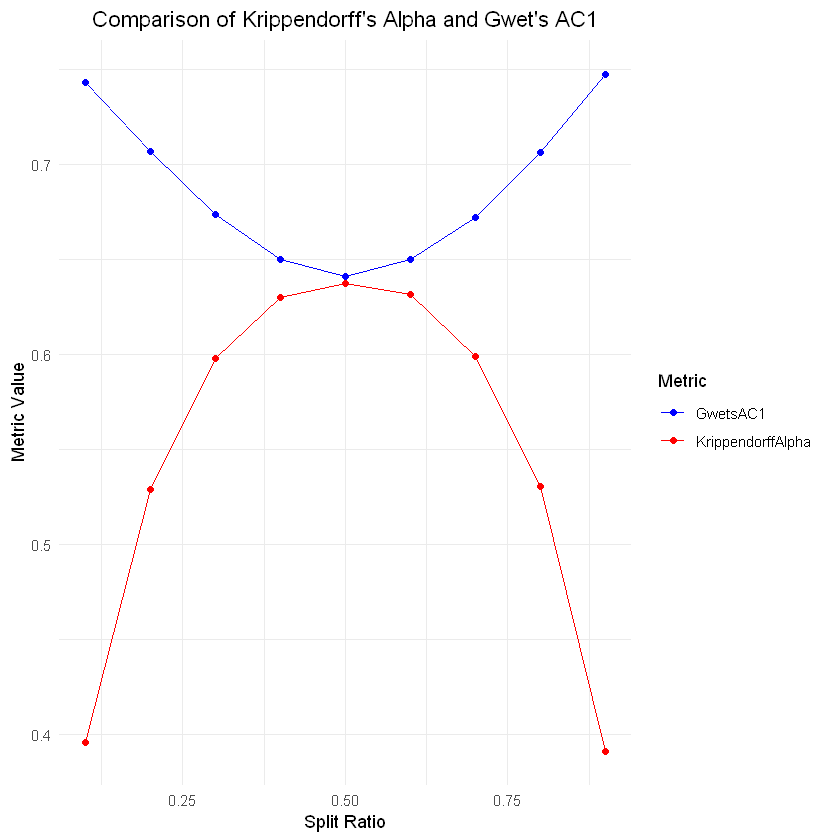

In [45]:
library(ggplot2)

# Assuming 'results' is already populated with the Krippendorff's Alpha and Gwet's AC1 values
# Reshape data for plotting with ggplot2
results_long <- tidyr::pivot_longer(results, cols = c("KrippendorffAlpha", "GwetsAC1"), 
                                    names_to = "Metric", values_to = "Value")

# Create the plot with two lines for each metric
ggplot(results_long, aes(x = SplitRatio, y = Value, color = Metric, group = Metric)) +
  geom_line() +  # Add line
  geom_point() +  # Add points
  scale_color_manual(values = c("blue", "red")) +  # Set custom colors for lines
  theme_minimal() +  # Minimal theme
  labs(x = "Split Ratio", y = "Metric Value", color = "Metric", 
       title = "Comparison of Krippendorff's Alpha and Gwet's AC1") +
  theme(plot.title = element_text(hjust = 0.5))  # Center the plot title

# Display the plot
ggsave("Krippendorff_vs_GwetsAC1.png", width = 8, height = 6)  # Save the plot as a PNG file


In [59]:
library(reshape2)

# Example usage of the function
total_items <- 100  # Adjust as needed
n_raters_per_item <- 5  # Adjust as needed
n_simulations <- 10  # Number of simulations for each combination

# Define accuracies and split ratios
accuracies <- seq(0.5, 0.9, by = 0.1)
split_ratios <- c(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9)

# Create an empty data frame to store results
results_alpha <- expand.grid(accuracy = accuracies, split_ratio = split_ratios)
results_alpha$KA <- NA  # Add a column to store Krippendorff's alpha

# Calculate Krippendorff's alpha for each combination of accuracy and split ratio
for (i in 1:nrow(results_alpha)) {
  ka_values <- numeric(n_simulations)
  for (j in 1:n_simulations) {
    ka_values[j] <- calculate_krippendorff_alpha_with_split_ratio(
      total_items, results_alpha$split_ratio[i], results_alpha$accuracy[i], n_raters_per_item)
  }
  results_alpha$KA[i] <- mean(ka_values)
}

# Reshape the data for presentation
results_table_alpha <- dcast(results_alpha, accuracy ~ split_ratio, value.var = "KA")



#____________________________________________________________________________________

# Create an empty data frame to store results
results_ac1 <- expand.grid(accuracy = accuracies, split_ratio = split_ratios)
results_ac1$AC1 <- NA  # Add a column to store Krippendorff's alpha

# Calculate Krippendorff's alpha for each combination of accuracy and split ratio
for (i in 1:nrow(results_ac1)) {
  ac1_values <- numeric(n_simulations)
  for (j in 1:n_simulations) {
    ac1_values[j] <- calculate_gwets_ac1_with_split_ratio(
      total_items, results_ac1$split_ratio[i], results_ac1$accuracy[i], n_raters_per_item)
  }
  results_ac1$AC1[i] <- mean(ac1_values)
}

# Reshape the data for presentation
results_table_ac1 <- dcast(results_ac1, accuracy ~ split_ratio, value.var = "AC1")

In [60]:
results_table_alpha
results_table_ac1

accuracy,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.5,-0.0004827851,-0.01686888,-0.0008066394,-0.002170839,0.005325856,-0.02332398,-0.002579849,0.01556156,-0.016934200
0.6,0.0072743048,0.01316546,0.0126294580,0.018574013,0.029336064,0.03188098,0.014451496,0.01235661,0.008289611
0.7,0.0554263874,0.11340088,0.1535402457,0.157125894,0.170076958,0.16133899,0.145061961,0.09029618,0.060194623
0.8,0.1414796601,0.26405222,0.3200579999,0.374869771,0.365995404,0.33522667,0.298425532,0.24990438,0.179181481
0.9,0.3990815286,0.55145115,0.6140917804,0.616792267,0.641521548,0.63088586,0.606873473,0.53125809,0.393894485


accuracy,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.5,0.002596,-0.002840,-0.006247,-0.006175,0.002482,-0.004200,0.010452,0.002072,-0.000701
0.6,0.060147,0.053635,0.027956,0.041667,0.057943,0.047892,0.038131,0.028310,0.061313
0.7,0.212120,0.177313,0.182860,0.168169,0.173509,0.192284,0.178992,0.190253,0.252911
0.8,0.500840,0.444457,0.396556,0.359359,0.357419,0.372759,0.382158,0.443644,0.488864
0.9,0.761892,0.695511,0.652329,0.665087,0.651108,0.630557,0.684687,0.707449,0.760134


In [74]:
# Assuming results_table is already created

# Apply the rounding to each numeric column
results_table_alpha_rounded <- results_table_alpha
numeric_columns <- sapply(results_table_alpha_rounded, is.numeric)
results_table_alpha_rounded[numeric_columns] <- round(results_table_alpha_rounded[numeric_columns], 2)

# Print the rounded results table
print(results_table_alpha_rounded)


  accuracy  0.1   0.2  0.3  0.4  0.5   0.6  0.7  0.8   0.9
1      0.5 0.00 -0.02 0.00 0.00 0.01 -0.02 0.00 0.02 -0.02
2      0.6 0.01  0.01 0.01 0.02 0.03  0.03 0.01 0.01  0.01
3      0.7 0.06  0.11 0.15 0.16 0.17  0.16 0.15 0.09  0.06
4      0.8 0.14  0.26 0.32 0.37 0.37  0.34 0.30 0.25  0.18
5      0.9 0.40  0.55 0.61 0.62 0.64  0.63 0.61 0.53  0.39


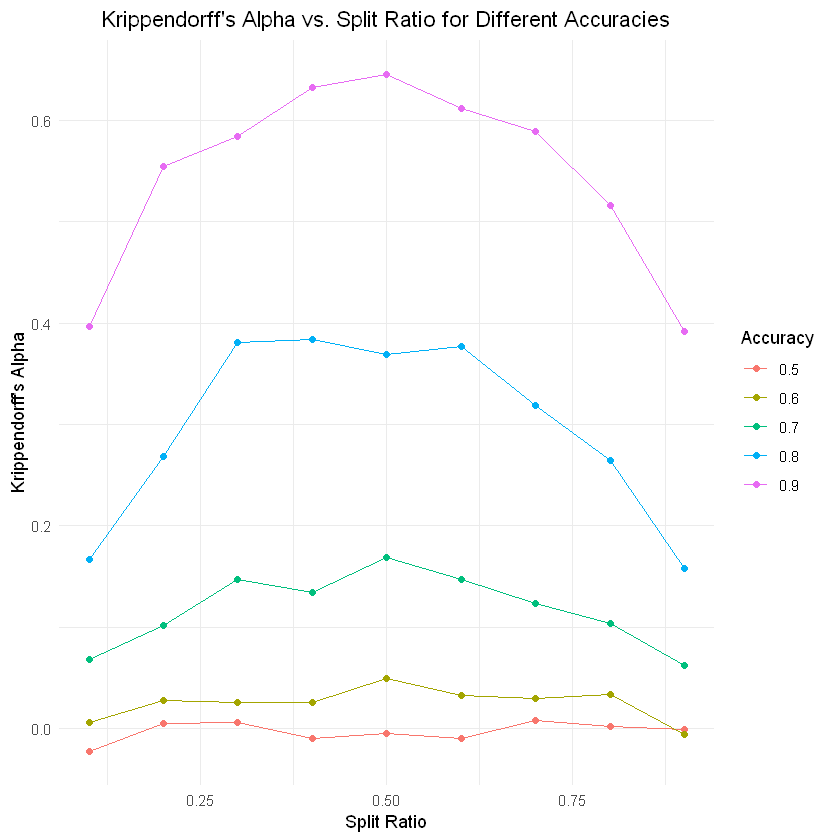

In [57]:
library(ggplot2)
library(reshape2)

# Assuming your results_table is already created and looks like the one you described

# Reshape the data into a long format for plotting
results_long <- melt(results_table_alpha, id.vars = "accuracy", variable.name = "split_ratio", value.name = "kripp_alpha")

# Convert split_ratio from factor to numeric for plotting
results_long$split_ratio <- as.numeric(as.character(results_long$split_ratio))

# Create the plot
ggplot(results_long, aes(x = split_ratio, y = kripp_alpha, group = accuracy, color = as.factor(accuracy))) +
  geom_line() +  # Add lines
  geom_point() +  # Add points
  theme_minimal() +  # Use a minimal theme
  labs(x = "Split Ratio", y = "Krippendorff's Alpha", color = "Accuracy") +
  ggtitle("Krippendorff's Alpha vs. Split Ratio for Different Accuracies") +
  theme(plot.title = element_text(hjust = 0.5))  # Center the plot title

# Display the plot

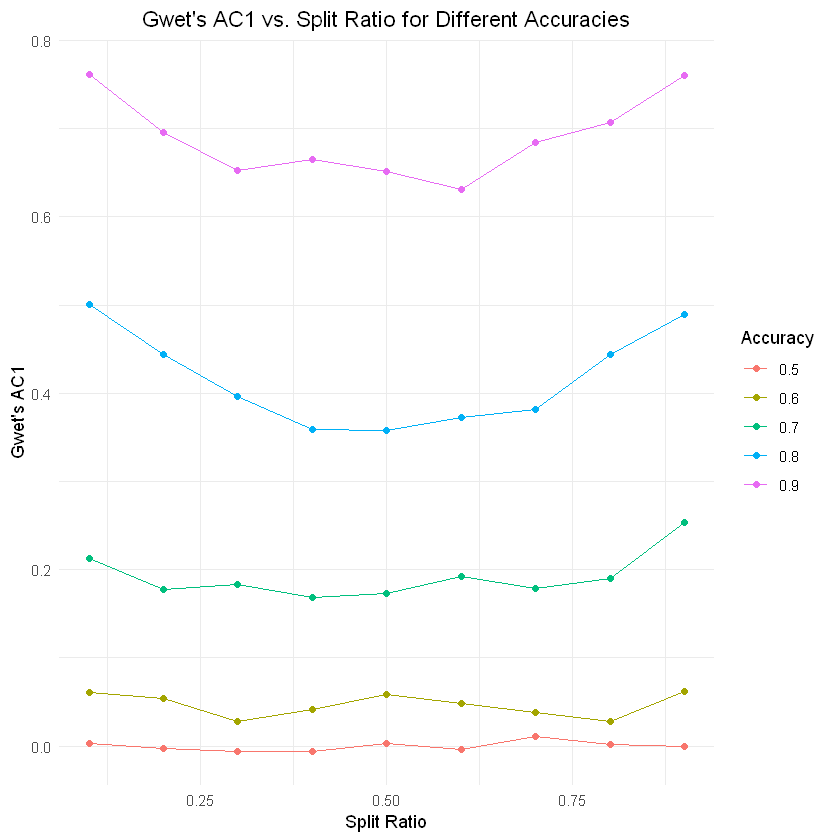

In [62]:
# Reshape the data into a long format for plotting
results_long <- melt(results_table_ac1, id.vars = "accuracy", variable.name = "split_ratio", value.name = "kripp_alpha")

# Convert split_ratio from factor to numeric for plotting
results_long$split_ratio <- as.numeric(as.character(results_long$split_ratio))

# Create the plot
ggplot(results_long, aes(x = split_ratio, y = kripp_alpha, group = accuracy, color = as.factor(accuracy))) +
  geom_line() +  # Add lines
  geom_point() +  # Add points
  theme_minimal() +  # Use a minimal theme
  labs(x = "Split Ratio", y = "Gwet's AC1", color = "Accuracy") +
  ggtitle("Gwet's AC1 vs. Split Ratio for Different Accuracies") +
  theme(plot.title = element_text(hjust = 0.5))  # Center the plot title

# Display the plot


In [2]:
# Install and load required packages
if (!requireNamespace("irr", quietly = TRUE)) {
  install.packages("irr")
}
library(irr)


Loading required package: lpSolve



95% Bootstrap Confidence Interval: 0.1715008 0.323935 


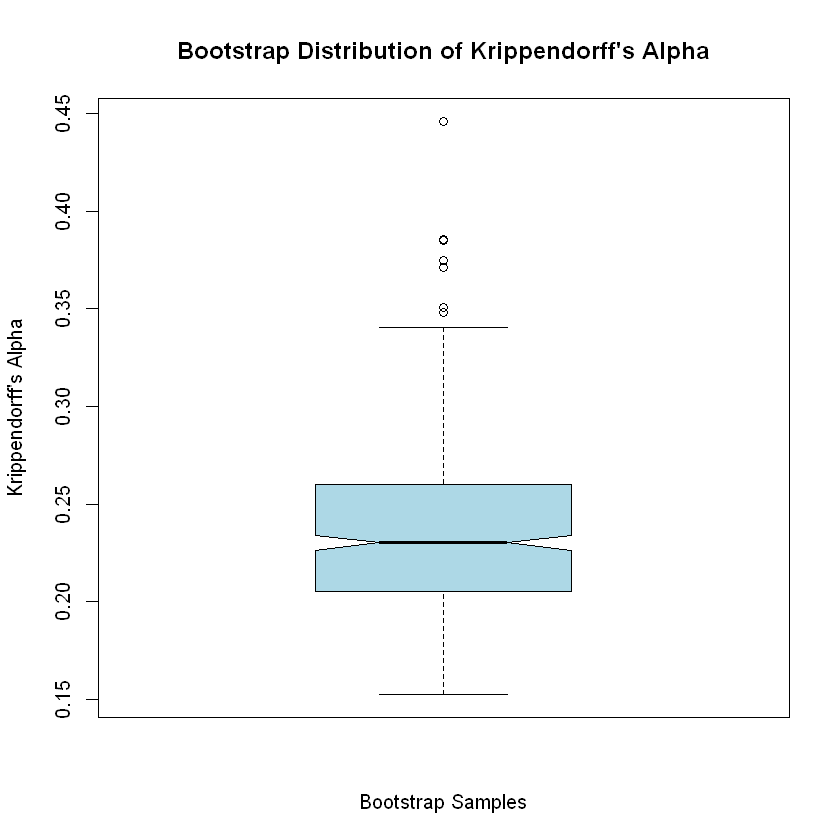

In [11]:
# Set seed for reproducibility
set.seed(42)

# Assuming binary_ratings_matrix is your data matrix

num_bootstraps <- 500  # choose the desired number of bootstrap samples

bootstrap_alphas <- replicate(num_bootstraps, {
  # Sample with replacement
  bootstrap_sample <- binary_ratings_matrix[sample(nrow(binary_ratings_matrix), replace = TRUE), ]
  # Compute Krippendorff's alpha for the bootstrap sample
  irr::kripp.alpha(bootstrap_sample, method = "nominal")$value
})

# Calculate confidence intervals
alpha_ci <- quantile(bootstrap_alphas, c(0.025, 0.975))

# Print the original alpha and confidence intervals
# cat("Original Alpha:", alpha_result$value, "\n")
cat("95% Bootstrap Confidence Interval:", alpha_ci, "\n")

# Create a boxplot
boxplot(bootstrap_alphas, main = "Bootstrap Distribution of Krippendorff's Alpha",
        xlab = "Bootstrap Samples", ylab = "Krippendorff's Alpha",
        col = "lightblue", border = "black", notch = TRUE)
